# Introduction to Word Embedding

Word embeddings are a way to represent words in a vector format such that similar words are occuring together in an N Dimension space.

Consider the following two sentences:
- I need a glass of <u>banana</u> juice
- I need a glass of <u>orange</u> juice

banana and orange are used in different sentences but they are syntactically same.

As mentioned in original Word2Vec paper,
"vector(”King”) - vector(”Man”) + vector(”Woman”) results in a vector that is closest to the vector representation of the word Queen"
<img src="files/w2c.png" alt="term-document matrix" style="width: 80%"/>


There are two ways in which we can learn word embeddings:
- CBOW
- Skip Gram
<img src="files/cbow_skip.png" alt="term-document matrix" style="width: 80%"/>

The CBOW architecture predicts the current word based on the
context, and the Skip-gram predicts surrounding words given the current word.

# Let's load the pretrained word embeddings and explore 
You can download pretrained word embeddings from Google: https://code.google.com/archive/p/word2vec/


In [1]:
from gensim.models import KeyedVectors

In [2]:
word_vectors = KeyedVectors.load_word2vec_format(
  'files/GoogleNews-vectors-negative300.bin',
  binary=True
)

/home/mohit/anaconda3/envs/gpu/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
def find_analogies(w1, w2, w3):
    r = word_vectors.most_similar(positive=[w1, w3], negative=[w2])
    print("%s - %s = %s - %s" % (w1, w2, r[0][0], w3))

def nearest_neighbors(w):
    r = word_vectors.most_similar(positive=[w])
    print("neighbors of: %s" % w)
    for word, score in r:
        print("\t%s" % word)

In [4]:
find_analogies('king', 'man', 'woman')
find_analogies('france', 'paris', 'london')
find_analogies('france', 'paris', 'rome')
find_analogies('paris', 'france', 'italy')
find_analogies('france', 'french', 'english')
find_analogies('man', 'doctor', 'homemaker')

king - man = queen - woman
france - paris = england - london
france - paris = italy - rome
paris - france = lohan - italy
france - french = england - english
man - doctor = woman - homemaker


# Train our own embeddings
Till now we have explored the pre trained word embeddings but based on your application and domain, sometimes you might need to train your own embeddings.

In the rest of the notebook we are going to build the embeddings using word2vec

In [5]:
#Load required packages
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from sklearn.utils import shuffle
from datetime import datetime
from scipy.spatial.distance import cosine as cos_dist
from sklearn.metrics.pairwise import pairwise_distances


from glob import glob

import os
import sys
import string

In [6]:
#Loading the text data on which we want to learn the embeddings:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [7]:
print("\n".join(newsgroups_train.data[:1]))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [8]:
all_word_counts = {}
#Remove Punctuation
for i in range(len(newsgroups_train.data)):
    sentences = newsgroups_train.data[i].split('.')
    for j in range(len(sentences)):
        s= sentences[j].translate(str.maketrans('', '', string.punctuation)).lower().split()
        if len(s)>1:
            for word in s:
                if word not in all_word_counts:
                    all_word_counts[word] = 0
                all_word_counts[word] += 1

In [9]:
#all_word_counts

In [10]:
len(all_word_counts)

133899

In [11]:
v_size = 10000

In [12]:
all_word_counts = sorted(all_word_counts.items(), key=lambda x: x[1], reverse=True)

top_words = [w for w, count in all_word_counts[:v_size-1]] + ['<UNK>']
word2idx = {w:i for i, w in enumerate(top_words)}
idx2word = {i:w for i, w in enumerate(top_words)}
unk = word2idx['<UNK>']

In [13]:
sents = []
for i in range(len(newsgroups_train.data)):
    sentences = newsgroups_train.data[i].split('.')
    for j in range(len(sentences)):
        s= sentences[j].translate(str.maketrans('', '', string.punctuation)).lower().split()
        if len(s) > 1:
            sent = [word2idx[w] if w in word2idx else unk for w in s]
            sents.append(sent)

In [14]:
st = sents[1]
for i in range(len(sents[1])):
    print(idx2word[st[i]])

edu
wheres
my
thing
subject
what
car
is
this
nntppostinghost
<UNK>


<img src="files/w2c_4.png"/>
<img src="files/w2c_5.png"/>

[source](https://blog.cambridgespark.com/tutorial-build-your-own-embedding-and-use-it-in-a-neural-network-e9cde4a81296)

# Get the context and negative sampling words

In [15]:
def get_context(pos, sentence, window_size):
  # input:
  # a sentence of the form: x x x x c c c pos c c c x x x x
  # output:
  # the context word indices: c c c c c c

    start = max(0, pos - window_size)
    end_  = min(len(sentence), pos + window_size)

    context = []
    for ctx_pos, ctx_word_idx in enumerate(sentence[start:end_], start=start):
        if ctx_pos != pos:
      # don't include the input word itself as a target
            context.append(ctx_word_idx)
    return context

In [16]:
def get_negative_sampling_distribution(sentences, vocab_size):
  # Pn(w) = prob of word occuring
  # we would like to sample the negative samples
  # such that words that occur more often
  # should be sampled more often

    word_freq = np.zeros(vocab_size)
    word_count = sum(len(sentence) for sentence in sentences)
#     print(word_count)
    for sentence in sentences:
#         print(sentence)
        for word in sentence:
            word_freq[word] += 1
    print(np.where(word_freq==0.0))

  # smooth it
    p_neg = word_freq**0.75
#     print(np.where(p_neg==0.0))
    
  # normalize it
    p_neg = p_neg / p_neg.sum()
    

    assert(np.all(p_neg > 0))
    return p_neg

# Model Building
We will use stochastic gradient descent to build the model

In [17]:
def sgd(input_, targets, label, learning_rate, W, V):
  # W[input_] shape: D
  # V[:,targets] shape: D x N
  # activation shape: N
  # print("input_:", input_, "targets:", targets)
    activation = W[input_].dot(V[:,targets])
    prob = sigmoid(activation)

  # gradients
    gV = np.outer(W[input_], prob - label) # D x N
    gW = np.sum((prob - label)*V[:,targets], axis=1) # D

    V[:,targets] -= learning_rate*gV # D x N
    W[input_] -= learning_rate*gW # D

  # return cost (binary cross entropy)
    cost = label * np.log(prob + 1e-10) + (1 - label) * np.log(1 - prob + 1e-10)
    return cost.sum()

In [18]:
# Setting the parameters to build the model
window_size = 5
learning_rate = 0.025
final_learning_rate = 0.0001
num_negatives = 5 # number of negative samples to draw per input word
epochs = 100
D = 50 # word embedding size
v_size = len(word2idx)
print(v_size)

10000


In [19]:
  # learning rate decay
learning_rate_delta = (learning_rate - final_learning_rate) / epochs


  # params
W = np.random.randn(v_size, D) # input-to-hidden
V = np.random.randn(D, v_size) # hidden-to-output


  # distribution for drawing negative samples
p_neg = get_negative_sampling_distribution(sents, v_size)


  # save the costs to plot them per iteration
costs = []


  # number of total words in corpus
total_words = sum(len(sentence) for sentence in sents)
print("total number of words in corpus:", total_words)

  # for subsampling each sentence
threshold = 1e-5
p_drop = 1 - np.sqrt(threshold / p_neg)

(array([], dtype=int64),)
total number of words in corpus: 3193919


In [20]:
# train the model
for epoch in range(epochs):
    # randomly order sentences so we don't always see
    # sentences in the same order
    np.random.shuffle(sents)

    # accumulate the cost
    cost = 0
    counter = 0
    t0 = datetime.now()
    for sentence in sents:
      # keep only certain words based on p_neg
        sentence = [w for w in sentence \
        if np.random.random() < (1 - p_drop[w])
      ]
        if len(sentence) < 2:
            continue


      # randomly order words so we don't always see
      # samples in the same order
        randomly_ordered_positions = np.random.choice(
        len(sentence),
        size=len(sentence),#np.random.randint(1, len(sentence) + 1),
        replace=False,
      )

      
        for pos in randomly_ordered_positions:
        # the middle word
            word = sentence[pos]

        # get the positive context words/negative samples
            context_words = get_context(pos, sentence, window_size)
            neg_word = np.random.choice(v_size, p=p_neg)
            targets = np.array(context_words)

        # do one iteration of stochastic gradient descent
            c = sgd(word, targets, 1, learning_rate, W, V)
            cost += c
            c = sgd(neg_word, targets, 0, learning_rate, W, V)
            cost += c

        counter += 1
        if counter % 100 == 0:
            sys.stdout.write("processed %s / %s\r" % (counter, len(sents)))
            sys.stdout.flush()
        # break


    # print stuff so we don't stare at a blank screen
    dt = datetime.now() - t0
    print("epoch complete:", epoch, "cost:", cost, "dt:", dt)

    # save the cost
    costs.append(cost)

    # update the learning rate
    learning_rate -= learning_rate_delta


epoch complete: 0 cost: -4874005.113858711 dt: 0:01:34.040225
epoch complete: 1 cost: -3181466.108185576 dt: 0:01:31.460299
epoch complete: 2 cost: -2716236.099439074 dt: 0:01:32.301783
epoch complete: 3 cost: -2503176.3089826494 dt: 0:01:32.223521
epoch complete: 4 cost: -2361092.032055076 dt: 0:01:32.084881
epoch complete: 5 cost: -2271202.1199086118 dt: 0:01:31.001518
epoch complete: 6 cost: -2208505.6593335653 dt: 0:01:30.608071
epoch complete: 7 cost: -2160062.672180178 dt: 0:01:30.499606
epoch complete: 8 cost: -2130223.453560899 dt: 0:01:31.528746
epoch complete: 9 cost: -2091870.4880585116 dt: 0:01:30.481441
epoch complete: 10 cost: -2059483.40797856 dt: 0:01:29.927754
epoch complete: 11 cost: -2047436.2614472047 dt: 0:01:30.256308
epoch complete: 12 cost: -2030890.4076422623 dt: 0:01:29.546088
epoch complete: 13 cost: -2005878.5552739983 dt: 0:01:28.697995
epoch complete: 14 cost: -1992923.5929452032 dt: 0:01:29.195739
epoch complete: 15 cost: -1993369.5584165754 dt: 0:01:29.0

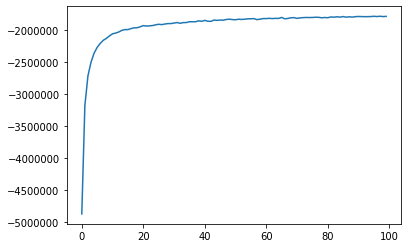

In [21]:
plt.plot(costs)
plt.show()

In [22]:
def analogy(pos1, neg1, pos2, neg2, word2idx, idx2word, W):
    V, D = W.shape

  # don't actually use pos2 in calculation, just print what's expected
    print("testing: %s - %s = %s - %s" % (pos1, neg1, pos2, neg2))
    for w in (pos1, neg1, pos2, neg2):
        if w not in word2idx:
            print("Sorry, %s not in word2idx" % w)
            return

    p1 = W[word2idx[pos1]]
    n1 = W[word2idx[neg1]]
    p2 = W[word2idx[pos2]]
    n2 = W[word2idx[neg2]]

    vec = p1 - n1 + n2

    distances = pairwise_distances(vec.reshape(1, D), W, metric='cosine').reshape(V)
    idx = distances.argsort()[:10]

  # pick one that's not p1, n1, or n2
    best_idx = -1
    keep_out = [word2idx[w] for w in (pos1, neg1, neg2)]
  # print("keep_out:", keep_out)
    for i in idx:
        if i not in keep_out:
            best_idx = i
            break
  # print("best_idx:", best_idx)

    print("got: %s - %s = %s - %s" % (pos1, neg1, idx2word[best_idx], neg2))
    print("closest 10:")
    for i in idx:
        print(idx2word[i], distances[i])

    print("dist to %s:" % pos2, cos_dist(p2, vec))

In [31]:
We = (W + V.T) / 2
analogy('jesus', 'christian', 'pet', 'islam', word2idx, idx2word, We)

testing: jesus - christian = pet - islam
got: jesus - christian = prophets - islam
closest 10:
jesus 0.16295655123190744
islam 0.19459131819666053
prophets 0.28321452998855934
islamic 0.29289037175281885
prophet 0.3011665914229881
god 0.3015252612867876
teachings 0.3086071810950065
contradiction 0.3212615651698495
verse 0.3216961507585706
humanity 0.32592826811968456
dist to pet: 0.8473193900060618


In [24]:
def tsne_plot():
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    counter = 0
    for word in word2idx:
        tokens.append(We[word2idx[word]])
        labels.append(word)
        if(counter>100):
            break
        counter += 1
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

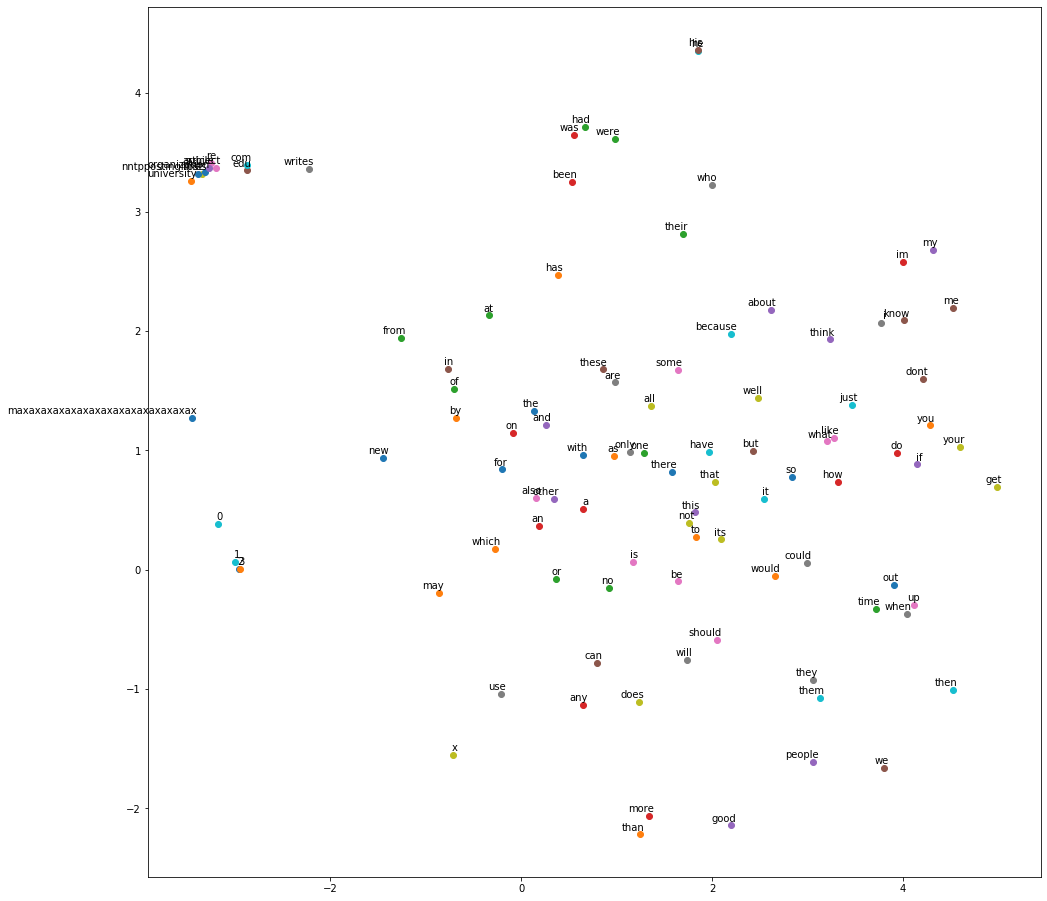

In [25]:
from sklearn.manifold import TSNE
tsne_plot()